In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.spatial import distance

import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.profiler import profile, record_function, ProfilerActivity

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFingerprintGenerator

In [2]:
smiles = ['CC1CN(c2cc(CNc3nc(Nc4cc(C(=O)N[Dy])ccc4Cl)nc(Nc4nccnc4Cl)n3)ccn2)CCO1',
       'O=C(N[Dy])c1cncc(Nc2nc(NCC3(N4CCOCC4)CC3)nc(Nc3c(O)ncnc3O)n2)n1',
       'Cc1cnc(Cl)nc1Nc1nc(NCC(C)c2c(Cl)cccc2Cl)nc(N[C@@H](Cc2ccc([N+](=O)[O-])cc2)C(=O)N[Dy])n1',
       'O=C(N[Dy])c1cccc(Nc2nc(NCCN3CCCS3(=O)=O)nc(Nc3cc(Cl)c([N+](=O)[O-])cn3)n2)c1',
       'C#CC[C@H](Nc1nc(NCCS(=O)(=O)Nc2ccccc2)nc(NCc2ccnc(C(N)=O)c2)n1)C(=O)N[Dy]',
       'COc1ccc(Nc2nc(Nc3cccc(S(C)(=O)=O)c3)nc(Nc3ccc(OC)c([N+](=O)[O-])c3)n2)c(C(=O)N[Dy])c1',
       'O=C(N[Dy])[C@@H](CCC1CCCCC1)Nc1nc(NCc2nccn2-c2ccccc2)nc(Nc2ccc(O)cc2C(F)(F)F)n1',
       'O=C(N[Dy])[C@H]1CC[C@@H](Nc2nc(Nc3ccnc(-c4ccccc4)c3)nc(Nc3cc(C4CC4)[nH]n3)n2)C1',
       'CCSC1CCC1(O)CNc1nc(Nc2cccc(I)c2C(=O)N[Dy])nc(Nc2cccc3ocnc23)n1',
       'COc1ccnc(Nc2nc(NCC#Cc3cccnc3)nc(N[C@H](Cc3ccc(Cl)c(Cl)c3)C(=O)N[Dy])n2)c1',
       'CC(CNc1nc(Nc2cc[nH]n2)nc(N[C@@H](CCC2CCCCC2)C(=O)N[Dy])n1)S(N)(=O)=O',
       'O=C(N[Dy])[C@@H]1Cc2ccc(O)cc2CN1c1nc(NCc2nnc(-c3ccncc3)[nH]2)nc(NCC2(N3CCOCC3)CCOCC2)n1',
       'COc1cccc(Nc2nc(Nc3ccc4c(c3)oc3ccccc34)nc(N[C@@H]3CN(C(=O)OC(C)(C)C)C[C@H]3C(=O)N[Dy])n2)n1',
       'Cn1ccnc1Cn1c(CCCNc2nc(Nc3ccnc(-c4ccccc4)c3)nc(N[C@@H](CCCN=[N+]=[N-])C(=O)N[Dy])n2)nc2c1CCCC2',
       'COC1(C(F)(F)CNc2nc(NCc3nnc(-c4ccncc4)[nH]3)nc(N3CCC[C@H]3C(=O)N[Dy])n2)CCOCC1',
       'COC(=O)c1cc(Nc2nc(Nc3ccc(Br)c(C(=O)N[Dy])c3)nc(Nc3ccc(C#N)cc3[N+](=O)[O-])n2)ccc1C',
       'Cc1cc(Cl)cc(Nc2nc(NCC3CC4(CC4)CO3)nc(Nc3ccc(CC(=O)N[Dy])cc3)n2)c1',
       'CCS(=O)(=O)N1CC(CNc2nc(NCCC3CCCC3(F)F)nc(Nc3nc(-c4ccc(C(=O)N[Dy])cc4)cs3)n2)C1',
       'COCC1(CNc2nc(NCC(O)c3ccc(Cl)s3)nc(N[C@@H](CC(=O)N[Dy])Cc3ccc([N+](=O)[O-])cc3)n2)CCCCC1',
       'Cc1cc(F)ccc1Nc1nc(NCc2cnns2)nc(NC2(C(=O)N[Dy])CCc3ccccc32)n1',
       'COC(=O)c1c[nH]nc1Nc1nc(Nc2cc(Br)cnc2C(=O)N[Dy])nc(Nc2cc(C)nn2-c2ccccc2)n1',
       'CC(C)(CCC#N)CNc1nc(Nc2cccnc2C(=O)N[Dy])nc(Nc2ncc(Cl)cc2F)n1',
       'N#Cc1c(Nc2nc(NCC3(O)CC3)nc(Nc3c(C(=O)O)cccc3C(=O)N[Dy])n2)sc2c1CCCC2',
       'Cc1cccc(CCCNc2nc(Nc3ccc(Br)c(C(=O)N[Dy])c3)nc(Nc3nccs3)n2)n1',
       'COC1(C(F)(F)CNc2nc(Nc3[nH]c(=O)ncc3F)nc(N3CCCC[C@H]3C(=O)N[Dy])n2)CCOCC1',
       'O=C(N[Dy])c1sc2ncccc2c1Nc1nc(NCCc2nccn2C(F)F)nc(NCc2cc(-c3ccccc3)[nH]n2)n1',
       'Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCN2CC[C@@H](O)C2)nc(NCc2cnns2)n1',
       'COc1cncc(Nc2nc(NCc3cn(C)nc3Br)nc(Nc3c(Br)cccc3C(=O)N[Dy])n2)n1',
       'COc1cnc(Nc2nc(NCC3CC4CC3C3CC43)nc(N3CCOC[C@@H]3C(=O)N[Dy])n2)nc1',
       'O=C(N[Dy])c1ccccc1C(=O)c1ccccc1Nc1nc(NCc2cccc3c2OCO3)nc(Nc2ccc(O)cc2C(F)(F)F)n1',
       'COC(=O)c1ccc2nc(Nc3nc(NCCc4ccno4)nc(N4CCCC[C@H]4C(=O)N[Dy])n3)sc2c1',
       'C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCCNC(=O)C(=C)C)nc(Nc2nc(-c3ccc(Cl)c(Cl)c3)cs2)n1',
       'CCSCCNc1nc(NCC2(F)CCCCC2)nc(Nc2ccc(C(=O)N[Dy])cc2F)n1',
       'N#Cc1c(Nc2nc(Nc3cncc(F)c3)nc(N[C@H](CC(=O)N[Dy])Cc3ccc(Br)cc3)n2)sc2c1CCCC2',
       'COc1cnc(CNc2nc(Nc3nnc(C)s3)nc(Nc3c(C(=O)N[Dy])ccc(F)c3OC)n2)cn1',
       'CCOC(=O)c1ncccc1Nc1nc(NCc2nnc3c(=O)[nH]ccn23)nc(Nc2nc(-c3ccc(C(=O)N[Dy])cc3)cs2)n1',
       'O=C(NCCNc1nc(NCc2cc3n(n2)CCCO3)nc(N[C@@H](Cc2c(F)c(F)c(F)c(F)c2F)C(=O)N[Dy])n1)c1ccn[nH]1',
       'O=C(N[Dy])[C@H](Cc1ccc(F)cc1F)Nc1nc(NCc2ccsc2C(F)(F)F)nc(Nc2cc(=O)[nH]c(=S)[nH]2)n1',
       'CN(CC(F)(F)F)C(=O)CNc1nc(NCC(C)(O)CN2CCOCC2)nc(Nc2c(OC(F)(F)F)cccc2C(=O)N[Dy])n1',
       'CN1CCN(Cc2cccc(Nc3nc(Nc4ccc(N5CCCC5=O)cc4)nc(NC4(C(=O)N[Dy])CC4)n3)c2)CC1',
       'COc1cc2c(cc1CNc1nc(NC[C@@H]3C[C@H](F)CN3Cc3ccnn3C)nc(N[C@H](CC(=O)N[Dy])Cc3cccs3)n1)OCO2',
       'COc1ccc([C@H](Nc2nc(NCCC(=O)NS(C)(=O)=O)nc(NCc3ccc(Oc4ccc(Cl)cc4Cl)c(C)c3)n2)C(=O)N[Dy])cc1',
       'O=C1CN(CCCNc2nc(Nc3ccc(F)c(C(F)(F)F)c3)nc(N3CC[C@@H]3C(=O)N[Dy])n2)CCN1',
       'COc1cnc(Nc2nc(NCc3nc(C)ccc3O)nc(N[C@H](Cc3ccc(I)cc3)C(=O)N[Dy])n2)nc1',
       'NC(=O)C1=NOC(CNc2nc(NCc3c[nH]c4ccccc34)nc(N[C@@H](Cc3ccco3)C(=O)N[Dy])n2)C1',
       'O=C(N[Dy])c1cccc(I)c1Nc1nc(NCc2cc(C(F)(F)F)co2)nc(Nc2cc(CO)ccn2)n1',
       'COC(=O)c1nccnc1Nc1nc(NC[C@H]2CC[C@H](C(N)=O)CC2)nc(Nc2ccc(C#N)cc2C(=O)N[Dy])n1',
       'COC(=O)c1cc(F)cc(Nc2nc(Nc3ccc(Cl)c(C#N)c3)nc(Nc3ccc(C(=O)N[Dy])cc3C(F)(F)F)n2)c1',
       'O=C(N[Dy])c1c(Br)ccc(F)c1Nc1nc(NCC2Cc3ccccc3NC2=O)nc(Nc2nccnc2Br)n1',
       'Cc1cc(Br)c(C(=O)N[Dy])cc1Nc1nc(NCc2cnc3n2CCOC3)nc(NCC(F)(F)CC2CC2)n1',
       'COc1cccc(F)c1CNc1nc(NCCN2C(=O)SC(=Cc3cccs3)C2=O)nc(N[C@H](Cc2ccc([N+](=O)[O-])cc2)C(=O)N[Dy])n1',
       'C#Cc1cccc(Nc2nc(Nc3ccc4c(cnn4C(=O)OC(C)(C)C)c3)nc(Nc3nc(-c4ccc(C(=O)N[Dy])cc4)cs3)n2)c1',
       'Cc1cc(Nc2nc(NCc3ccon3)nc(N[C@@H](Cc3ccc(F)c(F)c3)C(=O)N[Dy])n2)ccc1O',
       'CC(CNc1nc(NCCCc2nc3c(n2Cc2nccn2C)CCCC3)nc(Nc2c(C(=O)O)cccc2C(=O)N[Dy])n1)c1nccs1',
       'COC(=O)c1ccc(Nc2nc(NC[C@@H]3C[C@H](F)CN3Cc3ccnn3C)nc(Nc3ccc(F)cc3C(=O)N[Dy])n2)cc1O',
       'COC(=O)c1occc1Nc1nc(NC[C@@H]2CCC(=O)N2)nc(N[C@@H](Cc2ccsc2)C(=O)N[Dy])n1',
       'Cc1ccc(F)c(Nc2nc(NCc3noc(C4CCOCC4)n3)nc(N[C@@H](CC(=O)N[Dy])Cc3ccc(C(F)(F)F)cc3)n2)c1',
       'COCc1ccc(Nc2nc(Nc3nnc(C)o3)nc(Nc3c(C)cc(Cl)cc3C(=O)N[Dy])n2)cc1',
       'O=C(N[Dy])c1ccc(Nc2nc(NCc3cccs3)nc(Nc3nccc(-c4cccnc4)n3)n2)c(Cl)c1',
       'CC(C)(C)OCC(Nc1nc(NCC(=O)NC2CCC2)nc(Nc2nccc(Cl)n2)n1)C(=O)N[Dy]',
       'COc1c(F)cccc1Nc1nc(Nc2ccc(O)c(C)c2)nc(Nc2cccc(Cl)c2C(=O)N[Dy])n1',
       'C=CCOC(C)CNc1nc(NCC(C)Cn2cccn2)nc(Nc2c(I)cccc2C(=O)N[Dy])n1',
       'CN(CCNc1nc(NCC(O)COc2cccc(Cl)c2Cl)nc(N[C@H]2CCC[C@@H]2C(=O)N[Dy])n1)C1CCOCC1',
       'COc1cc(Nc2nc(NCCCc3cc(=O)[nH][nH]3)nc(NCc3ccnc(C(N)=O)c3)n2)c(C(=O)N[Dy])cc1OC',
       'O=C(N[Dy])[C@H](Nc1nc(NCCn2cc(C3CC3)nn2)nc(NCc2ncon2)n1)C1CCCC1',
       'COc1ccnc(Nc2nc(NCc3cc(Br)cc4cccnc34)nc(Nc3ccc(C(=O)N[Dy])c(Cl)c3)n2)n1',
       'CCOC(=O)c1ccc(O)c(Nc2nc(Nc3cnc(Cl)c(Cl)c3)nc(Nc3ccc(Cl)nc3C(=O)N[Dy])n2)c1',
       'O=C(N[Dy])c1ccc(Nc2nc(NCCOc3ccc(F)c(F)c3)nc(NCC3CCOC4(CCOCC4)C3)n2)cc1C(F)(F)F',
       'COc1cccc(-c2cc(Nc3nc(NCCC4CN(c5ncnc6[nH]ncc56)c5ccccc54)nc(Nc4ccc(CC(=O)N[Dy])cc4)n3)on2)c1',
       'COc1ccc(CNc2nc(Nc3ccc(N4CCOCC4)cc3)nc(N3Cc4ccccc4C[C@@H]3CC(=O)N[Dy])n2)c(C)c1OC',
       'O=C(NCCNc1nc(Nc2ccc(O)cn2)nc(Nc2ccc(Cl)cc2C(=O)N[Dy])n1)c1cnccn1',
       'COc1nc(C)ccc1CNc1nc(NCc2ccc(SC)o2)nc(Nc2cc(I)ccc2C(=O)N[Dy])n1',
       'O=C(C[C@@H](Cc1ccc(F)cc1)Nc1nc(NCc2ccc[n+]([O-])c2)nc(Nc2nc(-c3cccc([N+](=O)[O-])c3)cs2)n1)N[Dy]',
       'O=C(N[Dy])c1ccncc1Nc1nc(NCCc2c[nH]c3cc(Cl)ccc23)nc(Nc2nc3cccc(Br)n3n2)n1',
       'Cc1cc(F)ccc1Nc1nc(Nc2cc(C(F)(F)F)cnc2Cl)nc(Nc2c(I)c(C(=O)O)c(I)c(C(=O)N[Dy])c2I)n1',
       'O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc4ccccc4n3)nc(NCC3CCN(CC(F)F)CC3)n2)cn1',
       'C=CCOCCCNc1nc(NCC2CCCn3ccnc32)nc(N[C@@H](CCCN=[N+]=[N-])C(=O)N[Dy])n1',
       'COc1cc(CNc2nc(NCC3(S(C)=O)CCC3)nc(Nc3ccc(Cl)cc3C(=O)N[Dy])n2)sn1',
       'Cc1cc(Nc2nc(NCc3noc4ccc(F)cc34)nc(N[C@@H](CC(=O)N[Dy])c3ccc(C#N)cc3)n2)n[nH]1',
       'COc1ccc2nnc(CNc3nc(NCC(C)N4CCC4)nc(Nc4c(Cl)cccc4C(=O)N[Dy])n3)n2n1',
       'COC(=O)c1cnc(Nc2nc(NCCc3c(C)[nH][nH]c3=O)nc(Nc3ncc(C(=O)N[Dy])s3)n2)cn1',
       'Cn1cc(Nc2nc(NCC(F)(F)C(F)(F)F)nc(Nc3cc(F)c(Br)cc3C(=O)N[Dy])n2)ccc1=O',
       'Cn1nccc1[C@@H]1OCC[C@H]1CNc1nc(NCC2OCCc3ccsc32)nc(N[C@@H](C(=O)N[Dy])C2CCCCC2)n1',
       'CN1CCN(Cc2ccccc2Nc2nc(NCc3cc4ccccc4[nH]c3=O)nc(N3CCN(C(=O)OC(C)(C)C)C3C(=O)N[Dy])n2)CC1',
       'Cc1cc(F)cc(Nc2nc(NCc3ccncn3)nc(N[C@@H](CC(=O)N[Dy])Cc3ccc(F)cc3)n2)c1',
       'Cc1cccc(Nc2nc(NCc3cc(=O)c(O)co3)nc(N[C@H](CC(=O)N[Dy])Cc3ccc(C(F)(F)F)cc3)n2)c1Cl',
       'COc1cc(Nc2nc(NCC3(F)CCOC3)nc(Nc3ncnc4[nH]cnc34)n2)c(C(=O)N[Dy])c(OC)c1',
       'N#Cc1cnc2c(C#N)cnn2c1Nc1nc(NCC2(CO)CCOC2)nc(Nc2ccc(C(=O)N[Dy])cc2O)n1',
       'Cc1cc(Nc2nc(Nc3nc(-c4ccc(Cl)cc4)cs3)nc(Nc3cc(F)c(Br)cc3C(=O)N[Dy])n2)on1',
       'Cc1cccc2oc(CCNc3nc(NC[C@@H]4C[C@H](F)CN4Cc4ccnn4C)nc(Nc4cc(Br)ccc4C(=O)N[Dy])n3)nc12',
       'COc1cc(C(=O)N[Dy])c(Nc2nc(NCCC3CCCC3(F)F)nc(NCc3cncn3C)n2)cn1',
       'Cc1cc(Nc2nc(Nc3n[nH]c4ccc([N+](=O)[O-])cc34)nc(N3CCC[C@@]3(C)C(=O)N[Dy])n2)nnc1Cl',
       'CC(C)(C#N)c1ccc(Nc2nc(NCC3(CO)CCOC3)nc(N[C@@H](CC(=O)N[Dy])Cc3ccccc3Cl)n2)cc1',
       'CCOC(=O)c1cnn(C)c1Nc1nc(Nc2cc(N3CCCC3)ccn2)nc(Nc2c(F)ccc(Br)c2C(=O)N[Dy])n1',
       'COC(=O)c1cc(Nc2nc(Nc3ccc(O)c(C)c3)nc(Nc3ccc(C(=O)N[Dy])c([N+](=O)[O-])c3)n2)cs1',
       'CC(C)c1nc(Nc2nc(Nc3cc(Cl)ncn3)nc(N[C@@H](CC(=O)N[Dy])c3cccc(Cl)c3Cl)n2)sc1Br',
       'O=C(N[Dy])c1c(F)cccc1Nc1nc(Nc2ccc([N+](=O)[O-])c(C(F)(F)F)c2)nc(Nc2ncc(Cl)cc2F)n1',
       'O=C(N[Dy])[C@@H]1C[C@@H]2CCCC[C@@H]2N1c1nc(NCc2ccncn2)nc(Nc2ccncc2[N+](=O)[O-])n1',
       'C#CC[C@@](C)(Nc1nc(NCc2ccc(CN3C(=O)CNC3=O)cc2)nc(Nc2cc(Cl)nc(Cl)n2)n1)C(=O)N[Dy]',
       'COC1(CNc2nc(NCC3(S(C)=O)CCC3)nc(Nc3cc(F)cc(F)c3C(=O)N[Dy])n2)CCOC1']

In [5]:
mols = [Chem.MolFromSmiles(i) for i in smiles]

In [6]:
def get_fp_with_ao(mol, radius=2, fpSize=2048):
    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateAtomCounts() ## 원자의 수
    ao.AllocateAtomToBits() ## 원자가 어떤 비트로 맵핑되는지
    ao.AllocateBitInfoMap()
    
    fp = fpg.GetFingerprint(mol, additionalOutput=ao)
    return fp, ao

In [8]:
fp, ao = get_fp_with_ao(mols[0])
print(fp)
print(ao)

In [9]:
total_bits = fp.GetNumBits()
on_bits = fp.GetNumOnBits()

on_bits_list = list(fp.GetOnBits())

print(f'Total bits: {total_bits}, On Bits: {on_bits}, Sparsity: {on_bits/total_bits}')

Total bits: 2048, On Bits: 73, Sparsity: 0.03564453125


In [10]:
## GetBitInfoMap() 함수는 분자 내의 채워진 비트와 원자를 매핑하는 딕셔너리를 반환.
## 이 딕셔너리는 지문의 각 비트가 분자의 어떤 원자와 어떤 반경(radius)을 가지는지에 대한 정보를 포함합니다.
## 예를 들어, 47: ((26, 2),)는 비트 47이 원자 번호 26과 반경 2로 관련이 있음을 의미합니다.
## 47이 분자의 원자 번호 26과 관련이 있으며, 이 원자 주위 반경 2 내의 원자들이 이 비트를 채운다는 것을 의미

bit_info = ao.GetBitInfoMap()
bit_info

{47: ((26, 2),),
 80: ((7, 0),),
 84: ((22, 2),),
 157: ((28, 2),),
 203: ((2, 2),),
 206: ((1, 1),),
 255: ((7, 1), (8, 2)),
 339: ((32, 1),),
 366: ((22, 1),),
 378: ((10, 0), (24, 0), (28, 0), (31, 0), (34, 0), (37, 0)),
 407: ((3, 1),),
 475: ((40, 2),),
 486: ((16, 1),),
 491: ((12, 1), (26, 1)),
 493: ((35, 2),),
 510: ((14, 2),),
 526: ((15, 2),),
 527: ((4, 1),),
 530: ((37, 2),),
 555: ((12, 2),),
 561: ((23, 1), (33, 1)),
 586: ((3, 2),),
 621: ((16, 2),),
 639: ((5, 2),),
 650: ((17, 0),),
 656: ((40, 0),),
 666: ((21, 2),),
 708: ((27, 1),),
 739: ((2, 1),),
 787: ((36, 2),),
 802: ((40, 1),),
 807: ((16, 0),),
 875: ((5, 1), (14, 1)),
 926: ((2, 0), (38, 0), (39, 0)),
 933: ((13, 2),),
 935: ((3, 0),),
 950: ((39, 1),),
 1014: ((38, 2),),
 1019: ((1, 0),),
 1057: ((0, 0),),
 1063: ((31, 2),),
 1071: ((29, 2), (30, 2)),
 1152: ((8, 0), (12, 0), (18, 0), (26, 0)),
 1182: ((18, 1),),
 1184: ((24, 2), (10, 2), (34, 2)),
 1224: ((13, 1),),
 1225: ((18, 2),),
 1309: ((0, 1),),
 

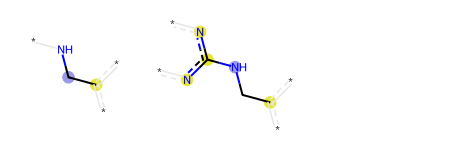

In [11]:
bit_idx = 255

Chem.Draw.DrawMorganBits([(mols[0], bit_idx, bit_info, i) 
                           for i in range(len(bit_info[bit_idx]))])

In [12]:
def get_bit_highlights(mol, atom_idx, radius):
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
    
    atoms = set((atom_idx, ))
    
    for bond_idx in env:
        bond = mol.GetBondWithIdx(bond_idx)
        
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        
        atoms.update([start_atom, end_atom])
        
    bonds = set()
    for atom_idx in atoms:
        atom = mol.GetAtomWithIdx(atom_idx)
        for bond in atom.GetBonds():
            bonds.add(bond.GetIdx())
            
    return atoms, bonds

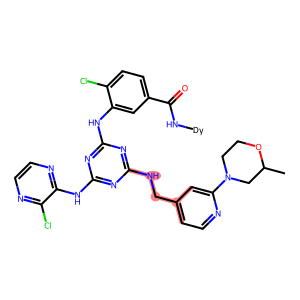

In [13]:
bit_atoms, bit_bonds = get_bit_highlights(mols[0], 7, 1)
Chem.Draw.MolToImage(mols[0], 
                     highlightAtoms=list(bit_atoms), 
                     highlightBonds=list(bit_bonds))

In [14]:
def plot_bit_features(mol, bit_info, bit_idx, **draw_kwargs):
    bit_tuples = bit_info[bit_idx]

    plot_mols = []
    atom_highlights = []
    bond_highlights = []

    for (atom_idx, radius) in bit_tuples:
        bit_atoms, bit_bonds = get_bit_highlights(mol, atom_idx, radius)
        atom_highlights.append(list(bit_atoms))
        bond_highlights.append(list(bit_bonds))
        plot_mols.append(mol)

    img = Chem.Draw.MolsToGridImage(plot_mols, 
                              highlightAtomLists=atom_highlights, 
                              highlightBondLists=bond_highlights,
                              **draw_kwargs
                             )
    return img

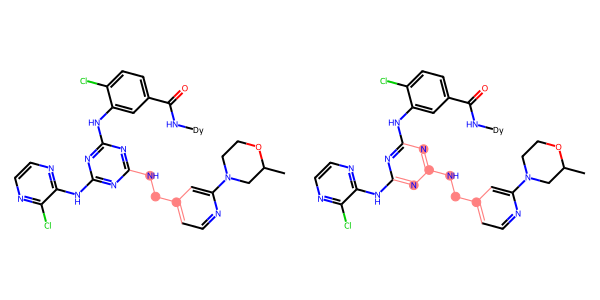

In [15]:
plot_bit_features(mols[0], bit_info, 255, molsPerRow=2, subImgSize=(300,300))

In [16]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fps = fpg.GetFingerprints(mols, numThreads=4)

In [17]:
def fp_to_np2(fp):
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [18]:
%%time
fps_np = [fp_to_np2(i) for i in fps]

CPU times: user 5.77 ms, sys: 0 ns, total: 5.77 ms
Wall time: 5.67 ms


In [25]:
print(type(fps_np))
print(fps_np)

test = np.array(fps_np)
print(np.unique(test))

<class 'list'>
[array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 1, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 1, ..., 0, 0, 0], dtype=int8), array([0, 0, 1, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 1, 1, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, ..., 0, 0, 0], dtype=int8), array([0, 0, 0, 

In [19]:
fp_packed = np.packbits(fps_np[0])
fp_packed.shape

(256,)

In [20]:
print(fps_np[0])
print(fp_packed)

[0 0 0 ... 0 0 0]
[  0   0   0   0   0   1   0   0   0   0 136   0   0   0   0   0   0   0
   0   4   0   0   0   0   0  18   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   0  16   0   0   2   0  32   0   0   1   0   0   0
   0   0   0   0   0  16   2  20   0   2   0   3  32   0   0  16  64   0
   0  32   0   0   0   4   0   1   0  32 128  32   0   0   0   0   8   0
   0   0  16   0   0   0   0   0  16   0  33   0   0   0   0   0   0   0
   0  16   0   0   0   0   0   2   5   0   2   0   0   0   0   0   0   0
   2  16   0   0   0   0  65   1   0   0   0   0   0   0   0   0   0   0
 128   0   0   2 128   0   0   0   0 192   0   0   0   0   0   0   0   0
   0   4   0   0   0   0   0   0   0   0   8  64   0   0   0 128   0   0
   0   8   0   0   0 128   0   0 128   0   0   0  32   0   0   0   0   2
   2   0   0   0   4   0   0   0   0   0   0   0  16   0  64   0   0   0
   0   0   2  32   0   0  16   0   0   0   0   8   0   0   0   1   0  32
  64   0   0   0   2   4 128   0 

In [28]:
# 예제 SMILES
smiles = ['CCO', 'CCN', 'CCC']
mols = [Chem.MolFromSmiles(i) for i in smiles]

# Morgan 지문 생성기 초기화
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fps = fpg.GetFingerprints(mols, numThreads=4)

# RDKit 내부 함수를 사용한 변환 함수
def fp_to_np(fp):
    arr = np.zeros((2048,), dtype=np.int8)  # 지문의 크기를 맞춤
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# 지문을 numpy 배열로 변환
fps_np = [fp_to_np(i) for i in fps]

tanimotos_rdkit = np.array([DataStructs.BulkTanimotoSimilarity(i, fps) for i in fps])
print(tanimotos_rdkit)

[[1.         0.33333333 0.42857143]
 [0.33333333 1.         0.42857143]
 [0.42857143 0.42857143 1.        ]]


In [ ]:
# 예제 SMILES
smiles = ['CCO', 'CCN', 'CCC']
mols = [Chem.MolFromSmiles(i) for i in smiles]

# Morgan 지문 생성기 초기화
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fps = fpg.GetFingerprints(mols, numThreads=4)

# 첫 번째 지문을 텐서로 변환
fp_tensor = torch.tensor(fps[0]).float()
fp_ints = torch.tensor(fps[0].GetOnBits()).long()

# 결과 출력
print(fp_ints)

In [ ]:
layer = nn.Linear(2048, 256, bias=False)

# 임베딩에 동일한 가중치 할당
embedding = nn.Embedding(2048, 256)
embedding.weight.data = layer.weight.data.T

# 임베딩 백에 동일한 가중치 할당
embedding_bag = nn.EmbeddingBag(2048, 256, mode='sum')
embedding_bag.weight.data = layer.weight.data.T

# 희소 벡터와 가중치 행렬의 행렬 곱셈
out1 = layer(fp_tensor)

# 임베딩 조회 및 합계
out2 = embedding(fp_ints).sum(0)

# 임베딩 백 조회 및 합계
out3 = embedding_bag(fp_ints, torch.tensor([0], dtype=torch.long))